In [1]:
%load_ext autoreload
%autoreload 2
notebook_fixed_dir = False

In [2]:
# this cell can only be called once
import os
if not notebook_fixed_dir:
    os.chdir('..')
    notebook_fixed_dir = True
print(os.getcwd())

/home/svcl-oowl/brandon/research/sil_consistent_at_inference


In [3]:
import pprint
import glob
from pathlib import Path
import pickle
import random

import torch
from PIL import Image
import numpy as np
from pytorch3d.renderer import look_at_view_transform
import matplotlib.pyplot as plt
import trimesh
from tqdm.autonotebook import tqdm
from pytorch3d.io import save_obj
import pandas as pd

from utils import general_utils, visualization_tools, nn_pose_est, eval_utils
from evaluation import compute_iou_2d, compute_iou_2d_given_pose, compute_iou_3d, compute_chamfer_L1, sample_points
from utils.brute_force_pose_est import brute_force_estimate_pose, brute_force_estimate_dist
from mesh_refiner import MeshRefiner

In [4]:
# shapenet
dataset_type = "shapenet"
class_name = "04090263"
gt_shapes_list_path = "data/gt_shapes_path_lists/shapenet_{}_gt_shapes.lst".format(class_name)

# regular
#input_img_dir = "data/input_images/pytorch3d_shapenet_renders/{}/rgba".format(class_name)
# atlasnet
#input_mesh_dir = "/home/svcl-oowl/brandon/research/AtlasNet/data/pytorch_3d_render_recs/{}".format(class_name)
# pix2mesh
#input_mesh_dir = "/home/svcl-oowl/brandon/research/Pixel2Mesh/rec_files/pytorch3d_shapenet_renders/{}/rgba".format(class_name)
# occnet
#input_mesh_dir = "/home/svcl-oowl/brandon/research/occupancy_networks/out/pytorch3d_renders/{}/generation/meshes".format(class_name)

# sym
input_img_dir = "data/input_images/sym_pytorch3d_shapenet_renders/{}/rgba".format(class_name)
input_mesh_dir = "/home/svcl-oowl/brandon/research/occupancy_networks/out/sym_pytorch3d_renders/{}/generation/meshes".format(class_name)


# pix3d
#dataset_type = "pix3d"
#class_name = "chair"
#input_mesh_dir = "/home/svcl-oowl/brandon/research/occupancy_networks/out/pix3d/{}/generation/meshes".format(class_name)
#input_img_dir = "data/pix3d_images_processed_filtered/{}/rgba".format(class_name)
#gt_shapes_list_path = "data/gt_shapes_path_lists/pix3d_{}_gt_shapes.lst".format(class_name)

In [6]:
#cfg_path = "configs/test.yaml"
cfg_path = "configs/final_refinement_params.yaml"
#cfg_path = "configs/ablation_4_params.yaml"

device = torch.device("cuda:0")
cfg = general_utils.load_config(cfg_path, "configs/default.yaml")
gt_shapes_dict = {}
with open(gt_shapes_list_path, 'r') as f:
    f = f.read().split('\n')
    for line in f:
        if line != "":
            gt_shapes_dict[line.split(" ")[0]] = line.split(" ")[1]
pose_dict = pickle.load(open(os.path.join(input_img_dir, "renders_camera_params.pt"), "rb"))
instances = [str(path).split('/')[-1].replace(".obj", "") for path in list(Path(input_mesh_dir).rglob("*.obj"))]

#instances = ['2394', '1517', '0191', '1598']
#instances = instances[:20]
# airplane sym
#instances = ["5eb91263da1f0bf3e816c75152573ee0", "9e998a06601e9f944b2bd73664dd1844"]
# chair sym
#instances = ["5ce845f80b1d407282dde982679cd879", "f7ffdf91b66c0c989c9513cebb0fb44c", "f9e7dcaf9b7a9eb3c9befbd10d7e29b", "b58a0307a86959bd564f6f5de611dfed"]
# speakers sym
#instances = ['8aea25f1090e419c9f78b1e1185445c4', '400fb89ed6cc3d2bf1acfa9a5200e941', '799a7910c5084f1a799c6c3b2fff049', 'fad354295b4c0fdb55266ce6303fe1e0']
# gun sym
instances = ['2a45063d7d03b865ebeab56de94a5835', '11b137bf4816ed40f4c39a35147bf949', '84de9995b0a416b5fb5c1b0f759e2bc1', '809d2439412bcdac896cb6094e2801d6', '938be7a1544953152c3271e911ffe19', '235853d2947a90e65e9786b1603f45c8']

print(instances)
print(cfg)

['2a45063d7d03b865ebeab56de94a5835', '11b137bf4816ed40f4c39a35147bf949', '84de9995b0a416b5fb5c1b0f759e2bc1', '809d2439412bcdac896cb6094e2801d6', '938be7a1544953152c3271e911ffe19', '235853d2947a90e65e9786b1603f45c8']
{'dataset': {'input_dir_mesh': 'data/onet_chair_shapent_no_DA_simplified', 'input_dir_img': 'data/img_shapenet_chair', 'gt_shapes_lst_path': 'data/gt_shapes_path_lists/shapenet_chair_gt_shapes.lst'}, 'brute_force_pose_est': {'num_azims': 20, 'num_elevs': 20, 'num_dists': 40}, 'model': {'point_encoder': 'ResnetPointnet', 'image_encoder': 'Resnet18', 'deformation_decoder': 'FCStandard', 'latent_dim_pointnet': 512, 'latent_dim_resnet': 256, 'decoder_dim': 1024, 'output_delta_V': True}, 'refinement': {'num_iterations': 350, 'learning_rate': 7e-05}, 'training': {'semantic_dis_lam': 0, 'img_sym_num_azim': 3, 'img_sym_lam': 100, 'sil_lam': 10, 'vertex_sym_lam': 0.0, 'l2_lam': 100, 'lap_smoothness_lam': 10, 'normal_consistency_lam': 10}, 'semantic_dis_training': {'output_dir': 'out

/home/svcl-oowl/brandon/research/occupancy_networks/out/sym_pytorch3d_renders/04090263/generation/meshes/2a45063d7d03b865ebeab56de94a5835.obj
0.6282051205635071 40.0 283.2682800292969 gt


/home/svcl-oowl/brandon/research/sil_consistent_at_inference/evaluation.py:73: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427286/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  input_img_mask = torch.tensor(np.asarray(input_img))[:,:,3] > 0


Input mesh metrics: {'2d_iou_multi': 0.08799084454464416, '2d_iou_input': 0.1669146865606308, '3d_iou': 0.0, 'chamfer_L1': 0.24705195426940918}


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



Refined mesh metrics: {'2d_iou_multi': 0.20219705626368523, '2d_iou_input': 0.8213472366333008, '3d_iou': 0.022591535, 'chamfer_L1': 0.10063053667545319}


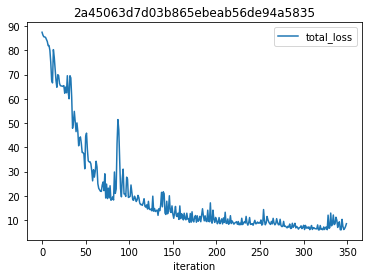

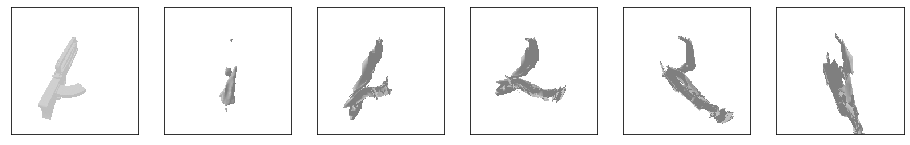

/home/svcl-oowl/brandon/research/occupancy_networks/out/sym_pytorch3d_renders/04090263/generation/meshes/11b137bf4816ed40f4c39a35147bf949.obj
1.0128204822540283 40.0 169.1722869873047 gt
Input mesh metrics: {'2d_iou_multi': 0.1888482212089002, '2d_iou_input': 0.031534817069768906, '3d_iou': 0.025697969, 'chamfer_L1': 0.04332882538437843}



Refined mesh metrics: {'2d_iou_multi': 0.27008578181266785, '2d_iou_input': 0.15726415812969208, '3d_iou': 0.0011239112, 'chamfer_L1': 0.029514024034142494}


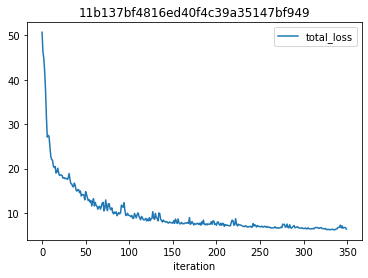

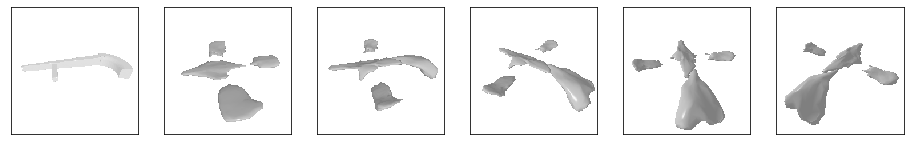

/home/svcl-oowl/brandon/research/occupancy_networks/out/sym_pytorch3d_renders/04090263/generation/meshes/84de9995b0a416b5fb5c1b0f759e2bc1.obj
0.8205128312110901 40.0 260.1707763671875 gt
Input mesh metrics: {'2d_iou_multi': 0.03609497655027857, '2d_iou_input': 0.0814153403043747, '3d_iou': 0.0, 'chamfer_L1': 0.13343863189220428}



Refined mesh metrics: {'2d_iou_multi': 0.21835151066382727, '2d_iou_input': 0.20288342237472534, '3d_iou': 0.009100999, 'chamfer_L1': 0.061893805861473083}


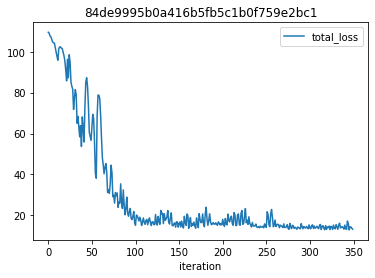

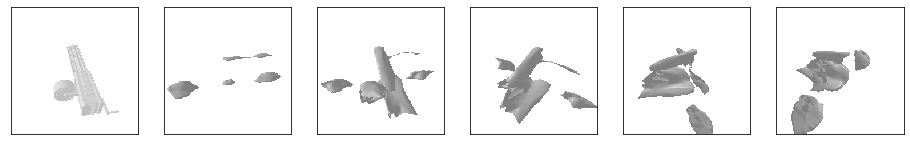

/home/svcl-oowl/brandon/research/occupancy_networks/out/sym_pytorch3d_renders/04090263/generation/meshes/809d2439412bcdac896cb6094e2801d6.obj
0.5641025900840759 40.0 296.020263671875 gt
Input mesh metrics: {'2d_iou_multi': 0.31155411278208095, '2d_iou_input': 0.6121850609779358, '3d_iou': 0.061953355, 'chamfer_L1': 0.005434437654912472}



Refined mesh metrics: {'2d_iou_multi': 0.31428486481308937, '2d_iou_input': 0.8172757625579834, '3d_iou': 0.041023713, 'chamfer_L1': 0.008917601779103279}


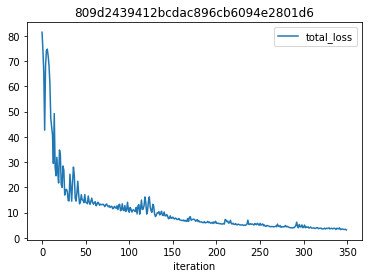

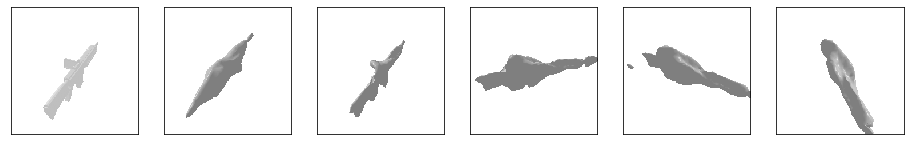

/home/svcl-oowl/brandon/research/occupancy_networks/out/sym_pytorch3d_renders/04090263/generation/meshes/938be7a1544953152c3271e911ffe19.obj
1.0769230127334595 40.0 248.85702514648438 gt
Input mesh metrics: {'2d_iou_multi': 0.1648945746322473, '2d_iou_input': 0.11603084951639175, '3d_iou': 0.07762628, 'chamfer_L1': 0.08793145418167114}



Refined mesh metrics: {'2d_iou_multi': 0.24923054811855158, '2d_iou_input': 0.4534892439842224, '3d_iou': 0.08097999, 'chamfer_L1': 0.05069702863693237}


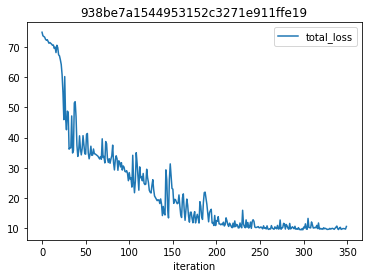

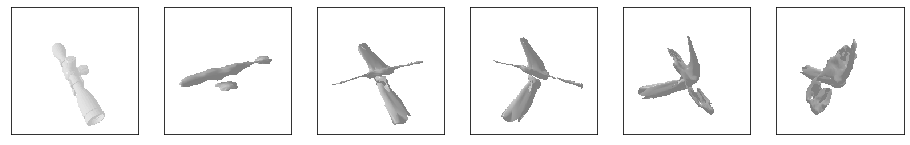

/home/svcl-oowl/brandon/research/occupancy_networks/out/sym_pytorch3d_renders/04090263/generation/meshes/235853d2947a90e65e9786b1603f45c8.obj
0.884615421295166 40.0 49.53357696533203 gt
Input mesh metrics: {'2d_iou_multi': 0.46749286353588104, '2d_iou_input': 0.5504363775253296, '3d_iou': 0.1674555, 'chamfer_L1': 0.005284145940095186}


In [ ]:
num_azims=20
num_elevs=20
num_dists=40

pose_settings=["gt"]
show_metrics = True

results_df = pd.DataFrame()
for instance in instances:
    input_img_path = os.path.join(input_img_dir,"{}.png".format(instance))
    input_image = np.asarray(Image.open(input_img_path))
    input_mesh_path = os.path.join(input_mesh_dir,"{}.obj".format(instance))
    print(input_mesh_path)
    gt_mesh_path = gt_shapes_dict[instance.split("_")[0]]
    with torch.no_grad():
        input_mesh = general_utils.load_untextured_mesh(input_mesh_path, device)
        gt_mesh = general_utils.load_untextured_mesh(gt_mesh_path, device)
    input_trimesh= trimesh.load(input_mesh_path)
    gt_trimesh = trimesh.load(gt_mesh_path)
    mask = np.asarray(input_image)[:,:,3] > 0
    
    instance_info = {"instance": instance}
    
    pose_info_list = []
    if "gt" in pose_settings:
        gt_elev = pose_dict[instance]["elev"]
        gt_azim = pose_dict[instance]["azim"]
        #gt_dist = pose_dict[instance]["dist"]
        _, _, gt_dist, _, _ = brute_force_estimate_dist(input_mesh, mask, gt_azim, gt_elev, num_dists, device)
        pose_info_list.append([gt_dist.item(), gt_elev, gt_azim, "gt"])
    if "bf" in pose_settings:
        bf_pred_azim, bf_pred_elev, bf_pred_dist, _, _ = brute_force_estimate_pose(input_mesh, mask, num_azims, num_elevs, num_dists, device)
        pose_info_list.append([bf_pred_dist.item(), bf_pred_elev.item(), bf_pred_azim.item(), "bf"])
        
    for (dist, elev, azim, name) in pose_info_list:
        #if dataset_type == "pix3d":
        #    azim = azim - 90
        #dist = float(dist)
        #elev = float(elev)
        #azim = float(azim)
        print(dist, elev, azim, name)
        if show_metrics:
            input_metrics_dict, input_debug_dict = eval_utils.eval_metrics(input_image, input_trimesh, input_mesh, gt_trimesh, 
                                                                           gt_mesh, device, metrics_to_eval=["2d_iou_multi", "2d_iou_input", "3d_iou", "chamfer_L1"],
                                                                           pred_azim=azim, pred_elev=elev, pred_dist=dist)
            instance_info = {**instance_info, **{"original_{}_{}".format(name, metric):input_metrics_dict[metric] for metric in input_metrics_dict}}
            print("Input mesh metrics: {}".format(input_metrics_dict))
        
        
        
        mesh_refiner = MeshRefiner(cfg, device)
        refined_mesh, loss_info = mesh_refiner.refine_mesh(input_mesh, input_image, dist, elev, azim)
        refined_mesh_path = os.path.join("notebooks/out", "{}_{}.obj".format(instance, name))
        save_obj(refined_mesh_path, refined_mesh.verts_packed(), refined_mesh.faces_packed())
        refined_trimesh = trimesh.load(refined_mesh_path)
        refined_mesh = general_utils.load_untextured_mesh(refined_mesh_path, device)
        if show_metrics:
            refined_metrics_dict, refined_debug_dict = eval_utils.eval_metrics(input_image, refined_trimesh, refined_mesh, gt_trimesh, gt_mesh, device, 
                                                                          metrics_to_eval=["2d_iou_multi", "2d_iou_input", "3d_iou", "chamfer_L1"],
                                                                          pred_azim=azim, pred_elev=elev, pred_dist=dist)
            print("Refined mesh metrics: {}".format(refined_metrics_dict))
            instance_info = {**instance_info, **{"refined_{}_{}".format(name, metric):refined_metrics_dict[metric] for metric in refined_metrics_dict}}

        loss_info.plot.line(x='iteration', y='total_loss', title="{}".format(instance))
        visualization_tools.show_refinement_results(input_image, input_mesh, refined_mesh, dist, elev, azim, device)
    
    results_df = results_df.append(instance_info, ignore_index=True)
    print("=========================================================================================")


In [ ]:
display(results_df)
print(results_df.mean())